# 1. Can you make the RNN model overfit using the high-level APIs?

Yes, you can intentionally design an RNN model to overfit using high-level APIs like PyTorch or TensorFlow. Overfitting occurs when a model learns to perform exceptionally well on the training data but fails to generalize to unseen data because it memorizes the training examples rather than learning the underlying patterns. To make an RNN model overfit, you can do the following:

1. **Create a Complex Model**: Design an RNN architecture with a large number of parameters. You can increase the number of hidden units, use multiple layers, and add complexity to the model to give it more capacity.

2. **Use Insufficient Training Data**: To promote overfitting, reduce the size of your training dataset. The smaller the dataset, the easier it is for the model to memorize it.

3. **Train for Many Epochs**: Train the model for an excessive number of epochs. Overfitting tends to occur as the model continues to improve on the training data but starts to perform poorly on validation or test data.

4. **Remove Regularization**: Avoid using regularization techniques like dropout, L1 or L2 regularization. Regularization methods are designed to prevent overfitting, so removing them can encourage overfitting.

5. **Disable Data Augmentation**: If you're working with sequences, you might apply data augmentation techniques like adding noise or jitter to the input data. Disabling these techniques can lead to overfitting.

# 2. Implement the autoregressive model of Section 9.1 using an RNN.

In [1]:
import numpy as np
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
from torch.nn import functional as F
from sklearn.model_selection import ParameterGrid
warnings.filterwarnings("ignore")

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4, randn=0.2):
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time) + torch.randn(T)*randn
        
    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        labels = [self.x[i:self.T-self.tau+i] for i in range(1,self.tau+1)]
        self.features = torch.stack(features, 1).unsqueeze(dim=-1).swapaxes(0, 1)
        self.labels = torch.stack(labels, 1).unsqueeze(dim=-1).swapaxes(0, 1)
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)
    
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)
    
class RNNAutoRegression(d2l.LinearRegression):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(1)

    # def output_layer(self, hiddens):
    #     return self.linear(hiddens).swapaxes(0, 1)
    
    def __init__(self, rnn,lr=0.01, tau=4, plot_flag=True, emb_len=8):
        super().__init__(lr=lr)
        self.save_hyperparameters()
        self.init_params()   

    def forward(self, X, state=None):
        rnn_outputs, _ = self.rnn(X, state)
        return self.linear(rnn_outputs[-1])
        # return rnn_outputs

/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/d2l.py:150: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'net'), 'Neural network is defined'
/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/d2l.py:154: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'trainer'), 'trainer is not inited'


In [2]:
tau=4
data = Data(tau=tau)
rnn = RNN(num_inputs=1, num_hiddens=8)
model = RNNAutoRegression(rnn=rnn, lr=0.01)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

(0.05530379340052605, 0)

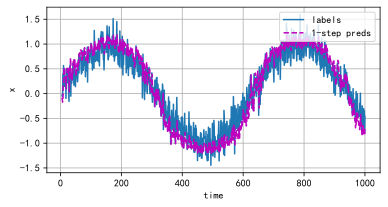

In [3]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.x[data.tau:], onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

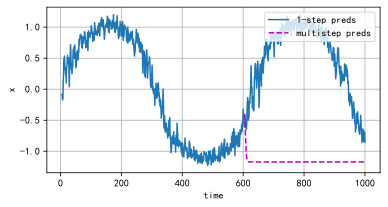

In [4]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((data.tau,1,1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))